In [ ]:
! python3 -m pip install --upgrade Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


In [ ]:
from PIL import Image
import numpy as np
import json
import math
from numpy.linalg import inv

with open('./teapot2.json') as json_file:
    data = json.load(json_file)

with open('./Scene.json') as json_file:
    Scene = json.load(json_file)


im=Image.new('RGB',[512,512],0x000000)
width,height=im.size
for y in range(height):
    for x in range(width):
        im.putpixel((x, y), (0, 0, 0, 255))


class Color:
    def __init__(self, red=0, green=0, blue=0):
        self.red = red
        self.green = green
        self.blue = blue

def computeVertexColor(normal, lights ,material,vertices):
    ka=material['Ka']
    kd=material['Kd']
    ks=material['Ks']
    n=material['n']
    N=normal

    d=np.array([0.0,0.0,0.0])
    s=np.array([0.0,0.0,0.0])

    la = np.dot(lights[0]['intensity'],lights[0]['color'])
    le=np.dot(lights[1]['intensity'],lights[1]['color'])

    L = np.subtract(lights[1]['from'], lights[1]['to'])
    L = L.astype(float)
    L /= np.linalg.norm(L)

    E=np.subtract([3,4,10],vertices)
    E/=np.linalg.norm(E)

    if np.dot(N,L)<0 and np.dot(N,E)<0:
      N = [-x for x in N]
    N/=np.linalg.norm(N)

    d = max(np.dot(N, L),0)
    d = min(1,d)*le

          #R = 2 * np.dot(N, L) * N - L
          #R/=np.linalg.norm(R)
    H=L+E
    H/=np.linalg.norm(H)

    s = max(np.dot(N,H),0)
    s=min(1,s)
    s =(s ** n) * le

    Cs=material['Cs']

    C=Cs*(la*ka+d*kd)+s*ks
    C = np.clip(C, 0, 1)
    triColor = Color()
    triColor.red = C[0]
    triColor.green = C[1]
    triColor.blue = C[2]

    return triColor


def interpolateColors(alpha, beta, gamma, color1, color2, color3):
    triColor = Color()
    triColor.red = alpha * color1.red + beta * color2.red + gamma * color3.red
    triColor.green = alpha * color1.green + beta * color2.green + gamma * color3.green
    triColor.blue = alpha * color1.blue + beta * color2.blue + gamma * color3.blue

    return triColor

def f(x, y,xa,ya,xb,yb):
    return (ya - yb) * x + (xb - xa) * y + xa * yb - xb * ya

def transfroamtion(T,S,R,vertices,norm):


  Trans=np.array([
    [1, 0,0, T[0]],
    [0, 1,0, T[1]],
    [0,0,1, T[2]],
    [0, 0, 0, 1]
  ])
  Scale=np.array([
    [S[0], 0,0, 0],
    [0, S[1],0, 0],
    [0,0,S[2], 0],
    [0, 0, 0, 1]
  ])
  if 'Rx' in R:
    Rotate=np.array([
        [1, 0, 0, 0],
        [0, np.cos(R['Rx']), -np.sin(R['Rx']), 0],
        [0, np.sin(R['Rx']), np.cos(R['Rx']), 0],
        [0, 0, 0, 1]
    ])
  if 'Ry' in R:
    Rotate=np.array([
        [np.cos(np.radians(R['Ry'])), 0, np.sin(np.radians(R['Ry'])), 0],
        [0, 1, 0, 0],
        [-np.sin(np.radians(R['Ry'])), 0, np.cos(np.radians(R['Ry'])), 0],
        [0, 0, 0, 1]
    ])
  if 'Rz' in R:
     Rotate=np.array([
        [np.cos(R['Rz']), -np.sin(R['Rz']), 0, 0],
        [np.sin(R['Rz']), np.cos(R['Rz']), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

  if(norm==1):
    I=np.dot(Scale,Rotate)
    I=inv(I)
    I=I.T
    I=np.dot(I,vertices)
    return I
  else:
    I=np.dot(Rotate,vertices)
    I=np.dot(Scale,I)
    I=np.dot(Trans,I)
    return I


def raster(vert):
  x_w = (vert[0]+1) * (511) / 2
  y_w = (1-vert[1]) * (511) / 2
  z_w= vert[2]
  return x_w,y_w,z_w

def interpolateNormals(alpha, beta, gamma, n1, n2, n3):
    normal=[0,0,0]
    normal[0]= alpha * n1[0] + beta *n2[0] + gamma * n3[0]
    normal[1]= alpha * n1[1] + beta *n2[1] + gamma * n3[1]
    normal[2]= alpha * n1[2] + beta *n2[2] + gamma * n3[2]
    return normal

<ipython-input-26-eab2da1b6e7d>:100: RuntimeWarning: invalid value encountered in scalar divide
  gamma = f(x,y,x0,y0,x1,y1) / f(x2,y2,x0,y0,x1,y1)
<ipython-input-26-eab2da1b6e7d>:98: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = f(x,y,x1,y1,x2,y2) / f(x0,y0,x1,y1,x2,y2)
<ipython-input-26-eab2da1b6e7d>:99: RuntimeWarning: divide by zero encountered in scalar divide
  beta = f(x,y,x2,y2,x0,y0) / f(x1,y1,x2,y2,x0,y0)


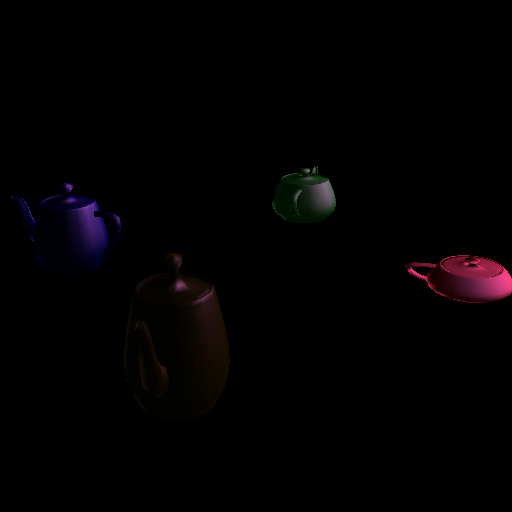

In [ ]:
number_of_teapots = Scene['scene']['shapes']
From=(Scene['scene']['camera']['from'])
To=(Scene['scene']['camera']['to'])

n=np.subtract(To,From)
n =n/np.linalg.norm(n)

u=np.cross(n,[0,1,0])
u =u/np.linalg.norm(u)

v=np.cross(u, n)
r=From

camera_matrix = ([
    [u[0], u[1], u[2], -np.dot(u,r)],
    [v[0], v[1], v[2], -np.dot(v,r)],
    [-n[0], -n[1], -n[2], np.dot(n,r)],
    [0, 0, 0, 1]
  ])

left=-1
right=1
top=1
bottom=-1
near = 3
far = 10
projection_matrix = ([
      [(2*near)/(right-left), 0, (right+left)/(right-left), 0],
      [0, (2*near)/(top-bottom), (top+bottom)/(top-bottom), 0],
      [0, 0, -(far + near) / (far - near), -2 * far * near / (far - near)],
      [0, 0, -1, 0]
  ])


for i in range(len(number_of_teapots)):
  with open('./teapot2.json') as json_file:
    data = json.load(json_file)
  R = Scene['scene']['shapes'][i]['transforms'][0]
  S = Scene['scene']['shapes'][i]['transforms'][1]['S']
  T = Scene['scene']['shapes'][i]['transforms'][2]['T']

  for item in data['data']:
    for vertexNum in ['v0', 'v1', 'v2']:
        x,y,z = item[vertexNum]['v'][:3]
        n1,n2,n3 = item[vertexNum]['n'][:3]
        vertices=[x,y,z,1]
        norm=[n1,n2,n3,0]

        vertices = transfroamtion(T,S,R,vertices,0)
        norm = transfroamtion(T,S,R,norm,1)

        vertices = np.dot(camera_matrix,vertices)

        norm = np.dot(camera_matrix,norm)

        item[vertexNum]['x']=vertices


        ndc_vertices = np.dot(projection_matrix, vertices)
        ndc_vertices /= ndc_vertices[3]

        x_rt, y_rt,z_rt=raster(ndc_vertices)

        item[vertexNum]['v'][0] = x_rt
        item[vertexNum]['v'][1] = y_rt
        item[vertexNum]['v'][2] = z_rt
        item[vertexNum]['n'][:3] = norm[:3]



  z_buffer = [[float('inf') for _ in range(width)] for _ in range(height)]
  lights = Scene['scene']['lights']
  material = Scene['scene']['shapes'][i]['material']

  for item in data['data']:
    x0, y0,z0 = item['v0']['v'][:3]
    x1, y1,z1 = item['v1']['v'][:3]
    x2, y2,z2= item['v2']['v'][:3]
    normal1 = item['v0']['n'][:3]
    normal2 = item['v1']['n'][:3]
    normal3 = item['v2']['n'][:3]
    vert1= item['v0']['x'][:3]
    vert2=item['v1']['x'][:3]
    vert3=item['v2']['x'][:3]
    color1 = computeVertexColor(normal1, lights,material,vert1)
    color2 = computeVertexColor(normal2, lights,material,vert2)
    color3 = computeVertexColor(normal3, lights,material,vert3)


    xmin = math.floor(min(x0, x1, x2))
    xmax = math.ceil(max(x0, x1, x2))
    ymin = math.floor(min(y0, y1, y2))
    ymax = math.ceil(max(y0, y1, y2))
    m=0

    for y in range(ymin,ymax):
      for x in range(xmin, xmax):
          alpha = f(x,y,x1,y1,x2,y2) / f(x0,y0,x1,y1,x2,y2)
          beta = f(x,y,x2,y2,x0,y0) / f(x1,y1,x2,y2,x0,y0)
          gamma = f(x,y,x0,y0,x1,y1) / f(x2,y2,x0,y0,x1,y1)
          if 0 <= alpha <=1  and 0 <= beta<=1  and 0<= gamma <=1:
            if 0 <= x < width and 0 <= y < height:
              z_at_pixel = alpha * z0 + beta * z1 + gamma * z2
              if z_at_pixel < z_buffer[x][y]:
                triangle_color = interpolateColors(alpha, beta, gamma, color1, color2, color3)
                im.putpixel((x, y), (int(255 * triangle_color.red), int(255 * triangle_color.green), int(255 * triangle_color.blue)))
                z_buffer[x][y] = z_at_pixel


im

<ipython-input-27-d40a11250526>:95: RuntimeWarning: invalid value encountered in scalar divide
  gamma = f(x,y,x0,y0,x1,y1) / f(x2,y2,x0,y0,x1,y1)
<ipython-input-27-d40a11250526>:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = f(x,y,x1,y1,x2,y2) / f(x0,y0,x1,y1,x2,y2)
<ipython-input-27-d40a11250526>:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = f(x,y,x2,y2,x0,y0) / f(x1,y1,x2,y2,x0,y0)


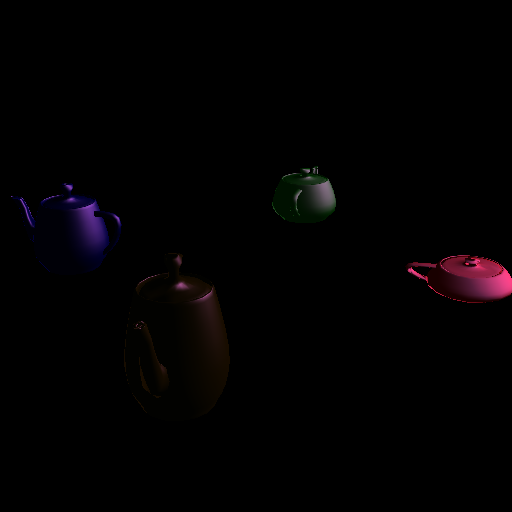

In [ ]:
number_of_teapots = Scene['scene']['shapes']
From=(Scene['scene']['camera']['from'])
To=(Scene['scene']['camera']['to'])

n=np.subtract(To,From)
n =n/np.linalg.norm(n)

u=np.cross(n,[0,1,0])
u =u/np.linalg.norm(u)

v=np.cross(u, n)
r=From

camera_matrix = ([
    [u[0], u[1], u[2], -np.dot(u,r)],
    [v[0], v[1], v[2], -np.dot(v,r)],
    [-n[0], -n[1], -n[2], np.dot(n,r)],
    [0, 0, 0, 1]
  ])


left=-1
right=1
top=1
bottom=-1
near = 3
far = 10
projection_matrix = ([
      [(2*near)/(right-left), 0, (right+left)/(right-left), 0],
      [0, (2*near)/(top-bottom), (top+bottom)/(top-bottom), 0],
      [0, 0, -(far + near) / (far - near), -2 * far * near / (far - near)],
      [0, 0, -1, 0]
  ])


for i in range(len(number_of_teapots)):
  with open('./teapot2.json') as json_file:
    data = json.load(json_file)
  R = Scene['scene']['shapes'][i]['transforms'][0]
  S = Scene['scene']['shapes'][i]['transforms'][1]['S']
  T = Scene['scene']['shapes'][i]['transforms'][2]['T']

  for item in data['data']:
    for vertexNum in ['v0', 'v1', 'v2']:
        x,y,z = item[vertexNum]['v'][:3]
        n1,n2,n3 = item[vertexNum]['n'][:3]
        vertices=[x,y,z,1]
        norm=[n1,n2,n3,0]

        vertices = transfroamtion(T,S,R,vertices,0)
        norm = transfroamtion(T,S,R,norm,1)

        vertices = np.dot(camera_matrix,vertices)
        norm = np.dot(camera_matrix,norm)

        item[vertexNum]['x']=vertices

        ndc_vertices = np.dot(projection_matrix, vertices)
        ndc_vertices /= ndc_vertices[3]

        x_rt, y_rt,z_rt=raster(ndc_vertices)

        item[vertexNum]['v'][0] = x_rt
        item[vertexNum]['v'][1] = y_rt
        item[vertexNum]['v'][2] = z_rt
        item[vertexNum]['n'][:3] = norm[:3]



  z_buffer = [[float('inf') for _ in range(width)] for _ in range(height)]
  lights = Scene['scene']['lights']
  material = Scene['scene']['shapes'][i]['material']

  for item in data['data']:
    x0, y0,z0 = item['v0']['v'][:3]
    x1, y1,z1 = item['v1']['v'][:3]
    x2, y2,z2= item['v2']['v'][:3]
    normal1 = item['v0']['n'][:3]
    normal2 = item['v1']['n'][:3]
    normal3 = item['v2']['n'][:3]
    vert1= item['v0']['x'][:3]
    vert2=item['v1']['x'][:3]
    vert3=item['v2']['x'][:3]

    xmin = math.floor(min(x0, x1, x2))
    xmax = math.ceil(max(x0, x1, x2))
    ymin = math.floor(min(y0, y1, y2))
    ymax = math.ceil(max(y0, y1, y2))
    m=0

    for y in range(ymin,ymax):
      for x in range(xmin, xmax):
          alpha = f(x,y,x1,y1,x2,y2) / f(x0,y0,x1,y1,x2,y2)
          beta = f(x,y,x2,y2,x0,y0) / f(x1,y1,x2,y2,x0,y0)
          gamma = f(x,y,x0,y0,x1,y1) / f(x2,y2,x0,y0,x1,y1)
          if 0 <= alpha <=1  and 0 <= beta<=1  and 0<= gamma <=1:
            if 0 <= x < width and 0 <= y < height:
              z_at_pixel = alpha * z0 + beta * z1 + gamma * z2
              if z_at_pixel < z_buffer[x][y]:
                normal = interpolateNormals(alpha,beta,gamma,normal1,normal2,normal3)
                vert = interpolateNormals(alpha,beta,gamma,vert1,vert2,vert3)
                triangle_color =computeVertexColor(normal, lights,material,vert)
                im.putpixel((x, y), (int(255 * triangle_color.red), int(255 * triangle_color.green), int(255 * triangle_color.blue)))
                z_buffer[x][y] = z_at_pixel


im